## Proportional representation of UK constituencies

The idea behind this project is to see how a proportional representation system would have altered results in the last UK general election. The plan is to merge neighbouring constituencies in the UK into 'super' constituencies with 2 / 3 / 4 / etc of them merged together into a larger one and use the D'Hondt method to allocate seats in this 'super' constituency.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp

import seaborn as sns

import time
import matplotlib.pyplot as plt

%matplotlib inline

# Algorithm X code
from algo_x import *

#### Simple PR model
The simplest PR model would multiply the percentage of votes gained nationally by the number of seats in the UK parliament (650). Which can be done simply using the following:

In [2]:
bes = pd.read_csv("../Data/bes_2019.csv")
bes = bes.rename(columns = 
                             {'con_vote_19': 'Conservative',
                             'lab_vote_19': 'Labour',
                             'ld_vote_19': 'Liberal Democrat',
                             'brexit_vote_19': 'Brexit party',
                             'green_vote_19': 'Green',
                             'snp_vote_19': 'Scottish National Party',
                             'pc_vote_19': 'Plaid Cymru',
                             'dup_vote_19': 'Democratic Unionist Party',
                             'sf_vote_19': 'Sinn Fein',
                             'sdlp_vote_19': 'Social Democratic & Labour Party',
                             'uup_vote_19': 'Ulster Unionist Party',
                             'alliance_vote_19': 'Alliance',
                             'other_vote_19': 'Other'})
bes_votes = bes[['total_vote_19', 'Conservative', 'Labour', 'Liberal Democrat',
                 'Brexit party', 'Green', 'Scottish National Party', 'Plaid Cymru',
                 'Democratic Unionist Party', 'Sinn Fein', 'Social Democratic & Labour Party', 
                 'Ulster Unionist Party', 'Alliance', 'Other']]
# Get total votes for each party
# Multiply by 649 as we remove the speaker's constituency
party_votes = bes_votes.fillna(0).apply(sum)
party_proportion = party_votes / party_votes['total_vote_19']
party_proportion = party_proportion.drop('total_vote_19')
list_pr_seats1 = pd.DataFrame(np.round(party_proportion * 649))
list_pr_seats1 = list_pr_seats1.rename(columns={0: 'orig_simple_pr'})

# Have a lot of votes for 'Other', so will remove them for this analysis since they can be spread across the whole country and it would be 
# difficult to know where to allocate the seats for them
party_proportion = party_votes / (party_votes['total_vote_19'] - party_votes['Other'])
party_proportion = party_proportion.drop(['Other','total_vote_19'])
list_pr_seats2 = pd.DataFrame(np.round(party_proportion * 649))
list_pr_seats2 = list_pr_seats2.rename(columns={0: 'simple_pr'})

In [3]:
seats = pd.DataFrame(pd.value_counts(bes['winner_19']))
seats = seats.rename(columns={'winner_19': 'FPTP'})
seats = seats.drop('Speaker')
seats = pd.concat([seats, list_pr_seats1, list_pr_seats2], axis = 1).fillna(0)
seats = seats.reset_index()
seats = seats.rename(columns={'index': 'Party'})

Text(0.5, 1.0, 'Comparison of seats won using different electoral systems')

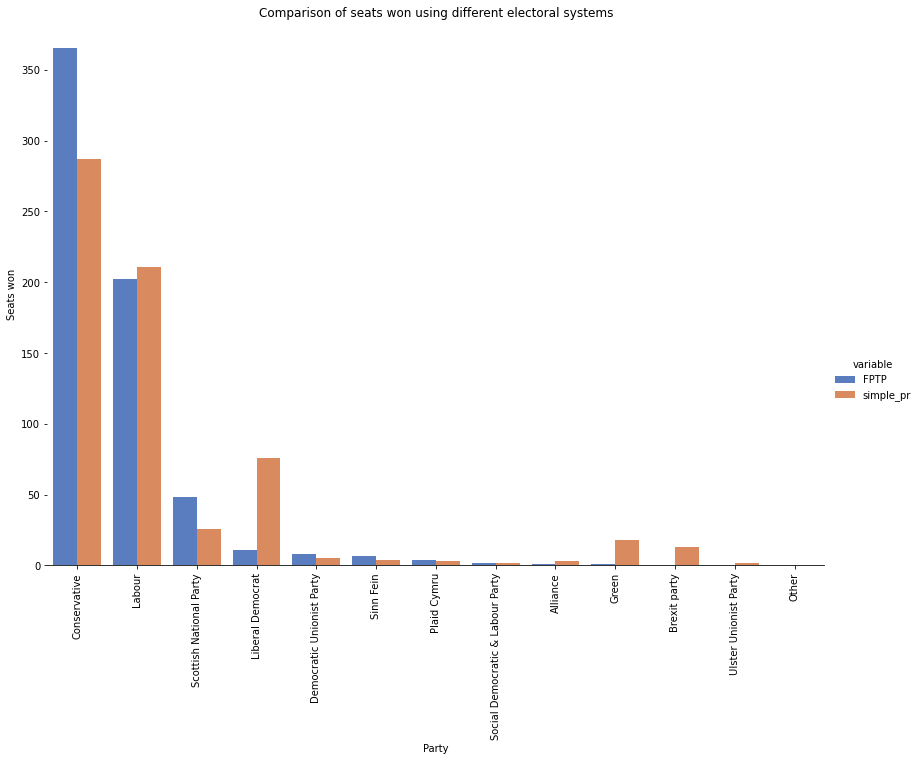

In [4]:
seats2 = pd.melt(seats, id_vars=['Party'], value_vars = ['FPTP', 'simple_pr'])
g = sns.catplot(x="Party", y="value", data=seats2, hue='variable', height=8.27, aspect=11.7/8.27,
                kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Seats won")
g.set_xticklabels(rotation=90)
plt.title("Comparison of seats won using different electoral systems")

We can see clearly that the Conservatives and SNP would have a much lower number of seats under this simple PR method, with the beneficiaries being the Liberal Democrats, Greens and the Brexit party.

#### D'Hondt method
As an initial model we shall apply the D'Hondt (and Webster) method to each statistical region in the UK and see what the results would have been in this scenario.

In [5]:
# Function to allocate seats using the D'Hont method
def seat_allocation(votes, no_of_seats=None, method = 'dhondt'):
    if no_of_seats is None:
        no_of_seats = len(votes)
    aggregated_votes = votes.apply(sum)
    aggregated_votes = aggregated_votes[aggregated_votes > 0]
    aggregated_votes = pd.DataFrame(aggregated_votes)
    aggregated_votes = aggregated_votes.rename(columns={0: 'Total votes'})
    aggregated_votes = aggregated_votes.assign(
        seats = 0,
        votes = aggregated_votes['Total votes']
    )
    for i in range(no_of_seats):
        name = aggregated_votes.index[np.argmax(aggregated_votes['votes'])]
        aggregated_votes.at[name, 'seats'] += 1
        if method == 'dhondt':
            aggregated_votes.at[name, 'votes'] = aggregated_votes.at[name, 'Total votes'] / (aggregated_votes.at[name, 'seats'] + 1)
        elif method == 'webster':
            aggregated_votes.at[name, 'votes'] = aggregated_votes.at[name, 'Total votes'] / (2*aggregated_votes.at[name, 'seats'] + 1)
    return aggregated_votes

In [6]:
parties = ['Conservative', 'Labour', 'Liberal Democrat',
                 'Brexit party', 'Green', 'Scottish National Party', 'Plaid Cymru',
                 'Democratic Unionist Party', 'Sinn Fein', 'Social Democratic & Labour Party', 
                 'Ulster Unionist Party', 'Alliance'] #, 'Other']
dhont_dict = {}
# Remove Speaker's constituency. 
bes2 = bes[bes['constituency_name'] != 'Chorley'].copy()
for region in np.unique(bes['region']):
    df = bes2[bes2['region'] == region][parties].fillna(0)
    dhont_dict[region] = seat_allocation(df)
dhondt_df = pd.concat(dhont_dict)

dhondt_df = dhondt_df.reset_index()
dhondt_df = dhondt_df.rename(columns = {'level_1': 'Party'})
dhondt_seats = dhondt_df[['Party','seats']].pivot_table(index='Party', aggfunc='sum')
dhondt_seats = pd.DataFrame(dhondt_seats).reset_index()
dhondt_seats = dhondt_seats.rename(columns={'seats': 'dhondt'})

webster_dict = {}
# Remove Speaker's constituency. 
bes2 = bes[bes['constituency_name'] != 'Chorley'].copy()
for region in np.unique(bes['region']):
    df = bes2[bes2['region'] == region][parties].fillna(0)
    webster_dict[region] = seat_allocation(df, method = 'webster')
webster_df = pd.concat(webster_dict)

webster_df = webster_df.reset_index()
webster_df = webster_df.rename(columns = {'level_1': 'Party'})
webster_seats = webster_df[['Party','seats']].pivot_table(index='Party', aggfunc='sum')
webster_seats = pd.DataFrame(webster_seats).reset_index()
webster_seats = webster_seats.rename(columns={'seats': 'webster'})

seats = seats.merge(dhondt_seats, how='outer').merge(webster_seats, how='outer').fillna(0)

Text(0.5, 1.0, 'Comparison of seats won using using different electoral systems')

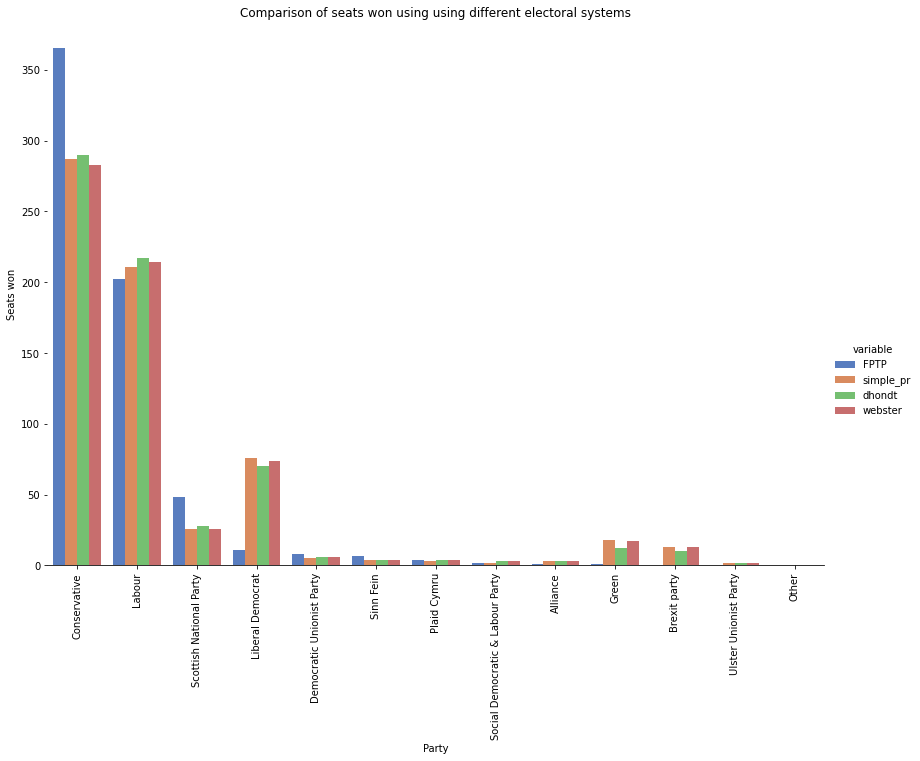

In [7]:
seats2 = pd.melt(seats, id_vars=['Party'], value_vars = ['FPTP', 'simple_pr', 'dhondt', 'webster'])
g = sns.catplot(x="Party", y="value", data=seats2, hue='variable', height=8.27, aspect=11.7/8.27,
                kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Seats won")
g.set_xticklabels(rotation=90)
plt.title("Comparison of seats won using using different electoral systems")

THe results are very similar to a 'simple' PR system, however this system would be a bit undesirable since we would have regions with large numbers of MPs (e.g. 'South East' with 84, 'Yorkshire and The Humber' with 54). This would really break the link between the constituent and the constituency MP. So as suggested what if, rather than the 'super' constituency being all of the constituencies in the region, we reduced the size of the 'super' constituency to be 2 / 3 / 4 / etc merged constituencies before we applied the D'Hondt method 

#### Creating 'super' constituencies
In order to merge neighbouring constituencies together we need their shapefiles.

In [32]:
df = gp.read_file("../Data/Westminster_Parliamentary_Constituencies_December_2017_UK_BFC/Westminster_Parliamentary_Constituencies_December_2017_UK_BFC.shp")
df = df.rename(columns={"PCON17NM": "Name"})

In [9]:
# Bit of string replacement so that we can merge the datasets.
df['merging_name'] = [str.replace(d.lower(), 'st. ', 'st ') for d in df['Name']]
bes['merging_name'] = [b.lower() for b in bes['constituency_name']]
# Now merge new information
df = df.merge(bes)
# Due to the Speaker's constituency (Chorley) not being contested we shall remove it from this analysis
df = df[df['Name'] != 'Chorley']

We also have an issue with the following constituencies in the 'Yorkshire and the Humber' region; 'Brigg and Goole', 'Scunthorpe', 'Cleethorpes' and 'Great Grimsby' since:

'Scunthorpe' only borders 'Brigg and Goole' (a)

'Great Grimsby' only borders 'Cleethorpes' (b)

'Cleethorpes' borders 'Cleethorpes' and 'Brigg and Goole' (c)

This means that when we merge two constituencies we know two of the sets, due to conditions (a) and (b)
When we want to merge four constituencies we have to combine (a) and (b)
It does, however, mean that we cannot have a solution when we want to merge 3 constituencies as if any set contains three of these neighbours then we would be left with either one or two remaining, i.e.
1. Set 1: ['Cleethorpes', 'Great Grimsby', 'Brigg and Goole'] leaves 'Scunthorpe' with no neighbours
1. Set 2: ['Scunthorpe', 'Great Grimsby', 'Brigg and Goole'] leaves 'Cleethorpes' with no neighbours
1. Set 3: ['Scunthorpe', 'Brigg and Goole', one of Brigg and Goole's neighbours] would leave 'Great Grimsby' and 'Cleethorpes' isolated as a single 
set of 2, but we would be looking at having sets of 3 constituencies.

As far as can be seen this is the only place in the UK where such a circular relationship occurs. So for now we will remove these places and add them in later when we want to analyse the voting data.

In [10]:
circular_consts = ['Brigg and Goole', 'Scunthorpe', 'Cleethorpes', 'Great Grimsby']
df = df[~df['Name'].isin(circular_consts)]

In [11]:
# The plan is to take every single constituency and find the 'neighbouring' constituency. We will use the 'disjoint' function from geopandas to
# find if two constituencies are not bordering.
# This will only be done on a region by region basis, as we are not interested in, say a Scotish constiuency that borders one in North 
# Eastern England.
pair_const = {}
regions = np.unique(df['region'])
k = 0
for region in regions:
    df2 = df[df['region'] == region]
    for i in range(len(df2)):
        for j in range(i+1, len(df2)):
            if not df2['geometry'].iloc[i].disjoint(df2['geometry'].iloc[j]):
                k += 1
                pair_const[k] = pd.DataFrame({'region': [region], 'set_no': k, 'name1': [df2['Name'].iloc[i]], 'name2': [df2['Name'].iloc[j]]})
const_pairs = pd.concat(pair_const).reset_index(drop=True)

In [12]:
# Now need to find all constituencies which haven't got a neighbouring constituency
paired_const = set(const_pairs['name1']).union(set(const_pairs['name2']))
unpaired_const = set(df['Name']).difference(paired_const)
print(unpaired_const)
# For the moment we will leave these out. 
# One reason is that 'Isle of Wight', 'Na h-Eileanan an Iar' and 'Orkney and Shetland' have protected status so that they have constituency
# boundaries defined exclusively by geography rather than by (or partly by) size of electorate.

{'Orkney and Shetland', 'Na h-Eileanan an Iar', 'Ynys Mon', 'Isle of Wight'}


To find merged constituencies of size 2 we can use the data frame `paired_const` filtered to just one region and then creating a dictionary which follows directly from the data frame.

In [13]:
# Quick function running algorithm X (for Exact cover of neighbouring constiuencies) and printing the total number of solutions
def all_solns(const_pairs, region, n=None):
    df = const_pairs[const_pairs['region'] == region_name]
    Y = {}
    for i in range(len(df)):
        Y[df['set_no'].iloc[i]] = {df['name1'].iloc[i], df['name2'].iloc[i]}

    all_solns = ExactCover(Y, random = True)
    i = 0
    for a in all_solns:
        i += 1
    # Find out how many constituencies there are in the dictionary.
    X = set([x for y in Y.values() for x in y])
    print(f"For the {region} region there are {i:,} solutions when there are {len(X)} constituencies.")

In [14]:
region_name = 'Northern Ireland'
start = time.time()
all_solns(const_pairs, region_name, n=10)
end = time.time()
print(f"The time taken is {end - start:.4f}s")

For the Northern Ireland region there are 129 solutions when there are 18 constituencies.
The time taken is 0.0055s


That works out quite nicely, however there are only 18 constituencies in the Northern Ireland region and it also contains an even number of constituencies. If we repeat the above for the 'North East' we will not have any solutions.

In [15]:
region_name = 'North East'
start = time.time()
all_solns(const_pairs, region_name)
end = time.time()
print(f"The time taken is {end - start:.4f}s")

For the North East region there are 0 solutions when there are 29 constituencies.
The time taken is 0.0042s


This is due to the 'North East' region having an odd number of constituencies. One possible solution for this might be to remove one constituency at random, however, apart from the 'island' constituencies, we're interested in merging them together so removing a 3-way merged constituency would seem an optimal solution. Note that there are a number of circumstances where this scenario would produce zero solutions, e.g. York Central is completely covered by York Outer, so if a triple merged constituency contained York Outer but not York Central then there would be no solutions.

For the moment we will only remove a singular three-merged constituenciy, as this is an inital analysis, but for later on we should look at running this multiple times with different choices, depending on the time taken for this analysis.

#### Finding three / four way neighbours
Now that we have neighbouring constituency pairs, let's see if we can find three and four way neighbours as well so that this idea can be expanded  to 'super' constituencies with three or four constituencies in them.

In [16]:
# The way we are going to do this is to see, for each set of neighbouring constituencies, find which other constituencies border them
# and then create a dataframe around that.
tri_const = {}
for i in range(len(const_pairs)):
    current_pair = const_pairs.iloc[i]
    to_find = current_pair[['name1','name2']].tolist()
    interim = const_pairs[
        (const_pairs['name1'].isin(to_find)) |
        (const_pairs['name2'].isin(to_find))
    ]
    if len(interim) > 1:
        neigh_const = set(interim['name1']).union(set(interim['name2']))
        neigh_const = neigh_const.difference(set(to_find))
        tri_const[i+1] = pd.DataFrame(
            {'region': current_pair['region'], 'name1': current_pair['name1'], 'name2': current_pair['name2'], 
             'name3': np.sort(list(neigh_const))})
const_tris = pd.concat(tri_const).reset_index(drop=True)
# Now need to remove duplicates
const_tris = const_tris.assign(
    combined_name = tuple([np.sort([a,b,c]) for a,b,c in zip(const_tris['name1'], const_tris['name2'], const_tris['name3'])])
)
const_tris = const_tris.drop_duplicates(subset = 'combined_name').reset_index(drop=True)
const_tris = const_tris.drop(columns='combined_name')
# Add set_no identifier
const_tris = const_tris.assign(set_no = const_tris.index+1)

In [17]:
# Also do for four-way neighbouring constituencies
quad_const = {}
for i in range(len(const_tris)):
    current_tri = const_tris.iloc[i]
    to_find = current_tri[['name1','name2','name3']].tolist()
    interim = const_pairs[
        (const_pairs['name1'].isin(to_find)) |
        (const_pairs['name2'].isin(to_find))
    ]
    if len(interim) > 1:
        neigh_const = set(interim['name1']).union(set(interim['name2']))
        neigh_const = neigh_const.difference(set(to_find))
        quad_const[i+1] = pd.DataFrame(
            {'region': current_tri['region'], 'name1': current_tri['name1'], 'name2': current_tri['name2'], 'name3': current_tri['name3'],
             'name4': np.sort(list(neigh_const))})
const_quads = pd.concat(quad_const).reset_index(drop=True)
# Now need to remove duplicates
const_quads = const_quads.assign(
    combined_name = tuple([np.sort([a,b,c,d]) for a,b,c,d in zip(const_quads['name1'], const_quads['name2'], const_quads['name3'], const_quads['name4'])])
)
const_quads = const_quads.drop_duplicates(subset = 'combined_name').reset_index(drop=True)
const_quads = const_quads.drop(columns='combined_name')
# Add set_no identifier
const_quads = const_quads.assign(set_no = const_quads.index+1)

In [18]:
region_name = 'North East'
const_tris_region = const_tris[const_tris['region'] == region_name]
random_tri =  const_tris_region[const_tris_region['set_no'] == 1368]
random_trit = random_tri[['name1','name2','name3']].values.tolist()[0]
const_pairs2 = const_pairs[(~const_pairs['name1'].isin(random_trit)) & (~const_pairs['name2'].isin(random_trit))]
start = time.time()
all_solns(const_pairs2, region_name)
end = time.time()
print(f"The time taken is {end - start:.4f}s")

For the North East region there are 44 solutions when there are 26 constituencies.
The time taken is 0.0041s


### Benchmark
So far we've seen how to implement Algorithm X. Now we want to test if there are ways of making it go faster. We'll use an example from the 'South East' region which is the largest of the regions we will be dealing with, however we have found that 'London' and  the 'North West' are the most time intensive regions to look at (more than likely due to those regions being more "regularly" shaped).

Note, though the South East region has 84 constituencies, one of them is the Isle of Wight, so we are left with 83.

In [19]:
# Using the algo_x code originally used.
region_name = 'South East'
# Pick out one of the 'triplets' 
random_trit = const_tris.iloc[2648] 
const_pairs2 = const_pairs[(~const_pairs['name1'].isin(random_trit)) & (~const_pairs['name2'].isin(random_trit))]
start = time.time()
all_solns(const_pairs2, region_name)
end = time.time()
print(f"The time taken is {end - start:.4f}s")

For the South East region there are 4,442,976 solutions when there are 80 constituencies.
The time taken is 136.4444s


Comparing results with another set of code for Algorithm X

In [20]:
from AlgorithmX import *

In [21]:
# Using AlgorithmX code
# This is the code that is installed when you run "pip install algorithm-x"
region_name = 'South East'
random_tri = const_tris.iloc[2648]
const_pairs2 = const_pairs[(~const_pairs['name1'].isin(random_tri)) & (~const_pairs['name2'].isin(random_trit))]
const_pairs3 = const_pairs2[const_pairs2['region'] == region_name]
const_list = list(set(const_pairs3['name1']).union(set(const_pairs3['name2'])))
# We need to replace the strings with numbers 
const_list = list(set(const_pairs3['name1']).union(set(const_pairs3['name2'])))
n = len(const_list)
mapping = {}
for i in range(n):
    mapping[const_list[i]] = i
const_pairs3 = const_pairs3.replace({'name1': mapping, 'name2': mapping})
solver = AlgorithmX(n)
for index, row in const_pairs3.iterrows():
    solver.appendRow([row['name1'], row['name2']], row['set_no'])
start = time.time()
i = 0
for solution in solver.solve():
    i += 1
end = time.time()
print(f"The time taken is {end - start:.4f}s")

The time taken is 98.1230s


This code is much quicker, though it's still impressive to find the approx. 4.4m results, results in only a few minutes.

In [22]:
# Save files to zipped csv's
const_pairs.to_csv("../Data/const_pairs.csv.gz", index=False, compression='gzip')
const_tris.to_csv("../Data/const_tris.csv.gz", index=False, compression='gzip')
const_quads.to_csv("../Data/const_quads.csv.gz", index=False, compression='gzip')

### Add election resuts
To save time later, for each set, we'll add the results that would have been obtained if that 'set_no' were the new constituency.

In [23]:
def add_results(df, bes, parties):
    df_long = pd.wide_to_long(df, stubnames=["name"], i=["region",'set_no'], j="test")
    df_long = df_long.reset_index()
    df_long = df_long.drop(columns='test')
    df_long['merging_name'] = [str.replace(d.lower(), 'st. ', 'st ') for d in df_long['name']]

    df_long = df_long.merge(bes[['merging_name','total_vote_19', *parties]])
    df_long = df_long.fillna(0)
    df_results = df_long.groupby('set_no')[parties].sum()
    df_results = df_results.astype(int)
    return df_results

In [24]:
df_results2 = add_results(const_pairs, bes, parties)
df_results3 = add_results(const_tris, bes, parties)
df_results4 = add_results(const_quads, bes, parties)

In [25]:
def allocation(x, no_of_seats=2, method='dhondt', cutoff=None):
    total_votes = sum(x)
    # Remove all parties which fail to meet the cutoff
    if cutoff is not None and cutoff > 0:
        cutoff_votes = round(cutoff * total_votes)
        x = x[x > cutoff_votes]
        total_votes = sum(x)
    df = pd.DataFrame(x)
    df = df.rename(columns={df.columns[0]: 'Total votes'})
    
    if method == 'simple_pr':
        df = df.assign(seats = round(df['Total votes']/total_votes * no_of_seats))
        df = df[df['seats'] > 0].drop(columns='Total votes')
    else:
        df = df.assign(seats = 0, votes = df['Total votes'])
        for i in range(no_of_seats):
            name = pd.Series.idxmax(df['votes'])
            df.at[name, 'seats'] += 1
            if method == 'dhondt':
                df.at[name, 'votes'] = df.at[name, 'Total votes'] / (df.at[name, 'seats'] + 1)
            elif method == 'webster':
                df.at[name, 'votes'] = df.at[name, 'Total votes'] / (2*df.at[name, 'seats'] + 1)
        df = df[df['seats'] > 0].drop(columns=['votes','Total votes'])
    df_dict = df.to_dict()
    return df_dict['seats']

In [26]:
def add_method(df, method = 'dhondt', seats=2, cutoff=None, parties=None):
    if method == 'simple_pr':
        df[method] = df[parties].apply(allocation, axis=1, no_of_seats = seats, method = method, cutoff=cutoff)
    elif ((method == 'dhondt') | (method == 'webster')):
        df[method] = df[parties].apply(allocation, axis=1, no_of_seats = seats, method = method)
    else:
        print("Incorrect method picked!!")
    df = df.reset_index()
    df2 = pd.concat([pd.DataFrame(d, index=[p]) for d, p in zip(df[method], df['set_no'])], sort=False)
    df2 = df2.fillna(0).apply(lambda x: x.astype(int), axis=1)
    df2 = df2.reset_index()
    df2 = df2.rename(columns={'index': 'set_no'})
    return df2

In [27]:
for method in ['dhondt','webster']:
    for s in [2,3,4]:
        if s == 2:
            df = add_method(df_results2, method=method, seats=s, parties=parties)
        elif s == 3:
            df = add_method(df_results3, method=method, seats=s, parties=parties)
        elif s == 4:
            df = add_method(df_results4, method=method, seats=s, parties=parties)
        filename = '../Data/MergedResults/const_merged_' + str(s) + "_" + method + ".csv.gz"
        df.to_csv(filename, index=False, compression='gzip')

#### Next step:
Run the Exact Cover algorithm for each region and store solutions. This will be done using a PyPy kernel so will be done separately.